<a href="https://colab.research.google.com/github/eldapere8/W207_ML_Projects/blob/main/elda_pere_project3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 3: Topic Classification using Naive Bayes

**Solution**

# Intro
---
In this project, you'll work with text data from newsgroup posts on a variety of topics. You'll train classifiers to distinguish posts by topics inferred from the text. Whereas with digit classification, where each input is relatively **dense** (represented as a 28x28 matrix of pixels, many of which are non-zero), here each document is relatively **sparse** (represented as a **bag-of-words**). Only a few words of the total vocabulary are active in any given document. The assumption is that a label depends only on the count of words, not their order.

The `sklearn` documentation on feature extraction may be useful:
http://scikit-learn.org/stable/modules/feature_extraction.html

Each problem can be addressed succinctly with the included packages -- please don't add any more. Grading will be based on writing clean, commented code, along with a few short answers.

As always, you're welcome to work on the project in groups and discuss ideas on Slack, but <b> please prepare your own write-up with your own code. </b>

## Grading
---
- Make sure to answer every part in every question.
 - There are 7 questions and one extra credit question. 
 - Read carefully what is asked including the notes.
 - Additional points may be deducted if:
   - the code is not clean and well commented, 
   - and if the functions or answers are too long.

 ## Requirements:
---
1. Comment your code.
1. All graphs should have titles, label for each axis, and if needed a legend. It should be understandable on its own.
1. All code must run on colab.research.google.com
1. You should not import any additional libraries.
1. Try and minimize the use of the global namespace (meaning keep things in functions).



In [1]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

# SK-learn library for importing the newsgroup data.
from sklearn.datasets import fetch_20newsgroups

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *

import nltk

Load the data, stripping out metadata so that only textual features will be used, and restricting documents to 4 specific topics. By default, newsgroups data is split into training and test sets, but here the test set gets further split into development and test sets.  (If you remove the categories argument from the fetch function calls, you'd get documents from all 20 topics.)

In [2]:
categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']
newsgroups_train = fetch_20newsgroups(subset='train',
                                      remove=('headers', 'footers', 'quotes'),
                                      categories=categories)
newsgroups_test  = fetch_20newsgroups(subset='test',
                                      remove=('headers', 'footers', 'quotes'),
                                      categories=categories)

num_test = int(len(newsgroups_test.target) / 2)
test_data, test_labels   = newsgroups_test.data[num_test:], newsgroups_test.target[num_test:]
dev_data, dev_labels     = newsgroups_test.data[:num_test], newsgroups_test.target[:num_test]
train_data, train_labels = newsgroups_train.data, newsgroups_train.target

print('training label shape:', train_labels.shape)
print('dev label shape:',      dev_labels.shape)
print('test label shape:',     test_labels.shape)
print('labels names:',         newsgroups_train.target_names)

training label shape: (2034,)
dev label shape: (676,)
test label shape: (677,)
labels names: ['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']


### Question 1: Examining your data
---

 1. For each of the first 5 training examples, print the text of the message along with the label (checkout newsgroups_train.target_names).

In [3]:
def Q1(num_examples=5):
    ### STUDENT START ###
    for i in range(num_examples):
      print("Text: ")
      print(train_data[i] + "\n")
      print("Label: " + newsgroups_train.target_names[train_labels[i]])
      print("-----------------------------------------------------------------")
    ### STUDENT END ###

Q1(5)

Text: 
Hi,

I've noticed that if you only save a model (with all your mapping planes
positioned carefully) to a .3DS file that when you reload it after restarting
3DS, they are given a default position and orientation.  But if you save
to a .PRJ file their positions/orientation are preserved.  Does anyone
know why this information is not stored in the .3DS file?  Nothing is
explicitly said in the manual about saving texture rules in the .PRJ file. 
I'd like to be able to read the texture rule information, does anyone have 
the format for the .PRJ file?

Is the .CEL file format available from somewhere?

Rych

Label: comp.graphics
-----------------------------------------------------------------
Text: 


Seems to be, barring evidence to the contrary, that Koresh was simply
another deranged fanatic who thought it neccessary to take a whole bunch of
folks with him, children and all, to satisfy his delusional mania. Jim
Jones, circa 1993.


Nope - fruitcakes like Koresh have been demonstra

### Question 2: Text representation
---

1. Transform the training data into a matrix of **word** unigram feature vectors.
  1. What is the size of the vocabulary? 
  1. What is the average number of non-zero features per example?  
  1. What is the fraction of the non-zero entries in the matrix?  
  1. What are the 0th and last feature strings (in alphabetical order)?
  - _Use `CountVectorization` and its `.fit_transform` method.  Use `.nnz` and `.shape` attributes, and `.get_feature_names` method._
1. Now transform the training data into a matrix of **word** unigram feature vectors restricting to the vocabulary with these 4 words: ["atheism", "graphics", "space", "religion"].  Confirm the size of the vocabulary. 
  1. What is the average number of non-zero features per example?
  - _Use `CountVectorization(vocabulary=...)` and its `.transform` method._
1. Now transform the training data into a matrix of **character** bigram and trigram feature vectors.  
  1. What is the size of the vocabulary?
  - _Use `CountVectorization(analyzer=..., ngram_range=...)` and its `.fit_transform` method._
1. Now transform the training data into a matrix of **word** unigram feature vectors and prune words that appear in fewer than 10 documents.  
  1. What is the size of the vocabulary?<br/>
  - _Use `CountVectorization(min_df=...)` and its `.fit_transform` method._
1. Now again transform the training data into a matrix of **word** unigram feature vectors. 
 1. What is the fraction of words in the development vocabulary that is missing from the training vocabulary?
 - _Hint: Build vocabularies for both train and dev and look at the size of the difference._

Notes:
* `.fit_transform` makes 2 passes through the data: first it computes the vocabulary ("fit"), second it converts the raw text into feature vectors using the vocabulary ("transform").
* `.fit_transform` and `.transform` return sparse matrix objects.  See about them at http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.sparse.csr_matrix.html. 

In [4]:
def Q2():
    ### STUDENT START ###
    print("1. ")
    cv = CountVectorizer(train_data)
    count_vector=cv.fit_transform(train_data)
    print("Vocabulary size is: " + str(count_vector.shape[1]))
    nonzero_features = round(count_vector.nnz/count_vector.shape[0], 5)
    print("Average number of non zero features is: " + str(nonzero_features))
    nonzero_frac = count_vector.nnz/(count_vector.shape[0] * count_vector.shape[1])
    print("Fraction of nonzero elements in the matrix is: " + str(round(nonzero_frac, 5)))
    print("First feature string: " + cv.get_feature_names()[0])
    print("Last feature string: " + cv.get_feature_names()[-1])

    print("-----------------------------------------------------------------------")
    print("2. ")
    cv2 = CountVectorizer(vocabulary =  ["atheism", "graphics", "space", "religion"])
    count_vector2=cv2.fit_transform(train_data)
    print("Vocabulary size is: " + str(len(cv2.vocabulary)))
    nonzero_features2 = round(count_vector2.nnz/count_vector2.shape[0], 5)
    print("Average number of non zero features is: " + str(nonzero_features2))
    print("-----------------------------------------------------------------------")
    print("3. ")
    cv3 = CountVectorizer(ngram_range=(2,3), analyzer = 'char')
    count_vector3=cv3.fit(train_data)
    print("Vocabulary size is: " + str(len(count_vector3.vocabulary_)))

    print("-----------------------------------------------------------------------")
    print("4. ")
    cv4 = CountVectorizer(min_df = 10)
    count_vector4=cv4.fit(train_data)
    print("Vocabulary size is: " + str(len(count_vector4.vocabulary_)))
    print("-----------------------------------------------------------------------")
    print("5. ")
    cv5 = CountVectorizer()
    count_vector5 = cv5.fit_transform(dev_data)
    cv6 = CountVectorizer()
    count_vector6 = cv6.fit_transform(train_data + dev_data)
    fraction_dev = (count_vector6.shape[1] -count_vector.shape[1])/count_vector5.shape[1]
    print("Fraction in dev: " + str(round(fraction_dev, 5)))
    print("-----------------------------------------------------------------------")

# 1. What is the fraction of words in the development vocabulary that is missing from the training vocabulary?
Q2()

1. 
Vocabulary size is: 26879
Average number of non zero features is: 96.706
Fraction of nonzero elements in the matrix is: 0.0036
First feature string: 00
Last feature string: zyxel
-----------------------------------------------------------------------
2. 
Vocabulary size is: 4
Average number of non zero features is: 0.26844
-----------------------------------------------------------------------
3. 
Vocabulary size is: 35478
-----------------------------------------------------------------------
4. 
Vocabulary size is: 3064
-----------------------------------------------------------------------
5. 
Fraction in dev: 0.24788
-----------------------------------------------------------------------


### Question 3: Initial model evaluation
---

1. Transform the training and development data to matrices of word unigram feature vectors.
1. Produce several k-Nearest Neigbors models by varying k, including one with k set to optimize f1 score.  For each model, show the k value and f1 score. 
1. Produce several Naive Bayes models by varying smoothing (alpha), including one with alpha set approximately to optimize f1 score.  For each model, show the alpha value and f1 score.
1. Produce several Logistic Regression models by varying L2 regularization strength (C), including one with C set approximately to optimize f1 score.  For each model, show the C value, f1 score, and sum of squared weights for each topic.
1. Why doesn't k-Nearest Neighbors work well for this problem?
1. Why doesn't Logistic Regression work as well as Naive Bayes does?
1. What is the relationship between logistic regression's sum of squared weights vs. C value?

Notes:
* Train on the transformed training data.
* Evaluate on the transformed development data.
* You can use `CountVectorizer` and its `.fit_transform` and `.transform` methods to transform data.
* You can use `KNeighborsClassifier(...)` to produce a k-Nearest Neighbors model.
* You can use `MultinomialNB(...)` to produce a Naive Bayes model.
* You can use `LogisticRegression(C=..., solver="liblinear", multi_class="auto")` to produce a Logistic Regression model.
* You can use `LogisticRegression`'s `.coef_` method to get weights for each topic.
* You can use `metrics.f1_score(..., average="weighted")` to compute f1 score.

In [5]:
def Q3():
    ### STUDENT START ###
    print("1. ")
    cv = CountVectorizer()
    count_vector_train = cv.fit_transform(train_data)
    count_vector_dev = cv.transform(dev_data)

    print("-----------------------------------------------------------------------")
    print("2. ")
    print("K Nearest Neighbor Models")
    for k in range(1, 10):
      knn = KNeighborsClassifier(n_neighbors=k)
      knn.fit(count_vector_train, train_labels)    
      dev_pred = knn.predict(count_vector_dev)
      score = metrics.f1_score(dev_labels, dev_pred, average = "weighted")
      print("k = " + str(k) + " ---> " + str(score))

    print("-----------------------------------------------------------------------")
    print("3. ")
    print("Naive Bayes Models")
    for a in [0.001, 0.01, 0.1, 0.25, 0.5, 0.75, 1, 2, 5]:
      mnb = MultinomialNB(alpha = a)
      mnb.fit(count_vector_train, train_labels)    
      dev_pred = mnb.predict(count_vector_dev)
      mnb_score = metrics.f1_score(dev_labels, dev_pred, average = "weighted")
      print("alpha = " + str(a) + " ---> " + str(mnb_score))

    print("-----------------------------------------------------------------------")
    print("4. ")
    print("Logistic Regression Models")
    for c in [0.00001, 0.00005, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 1, 2, 5]:
      lr = LogisticRegression(C=c, solver="liblinear", multi_class="auto")
      lr.fit(count_vector_train, train_labels)    
      dev_pred = lr.predict(count_vector_dev)
      lr_ssw = round(sum(sum((lr.coef_)**2)), 5)
      lr_score = metrics.f1_score(dev_labels, dev_pred, average = "weighted")
      print("C = " + str(c) + " and sum of squared weights = " + str(lr_ssw) + " ---> " + str(lr_score))

    print("-----------------------------------------------------------------------")
    print("5. ")
    print("K Nearest Neighbors does not work well because the data is multidimensional leading to curse of dimensionality, and the sparsity in distances makes training by distance difficult.")
    print("-----------------------------------------------------------------------")
    print("6. ")
    print("The logistic regression does not work as well as Naive Bayes because Naive Bayes converges quicker than Logistic Regression does due to it being a generative model.")
    print("-----------------------------------------------------------------------")
    print("7. ")
    print("The C parameter is the inverse of the lambda value which multiplies the sum of squared weights, used together as a regularization term in L2 regularization.")

    ### STUDENT END ###

Q3()

1. 
-----------------------------------------------------------------------
2. 
K Nearest Neighbor Models
k = 1 ---> 0.3805030018531525
k = 2 ---> 0.38054212404441684
k = 3 ---> 0.4084150225437623
k = 4 ---> 0.4031227993847515
k = 5 ---> 0.4287607236218357
k = 6 ---> 0.4466650540867595
k = 7 ---> 0.45047910006117586
k = 8 ---> 0.44698358117081094
k = 9 ---> 0.4365666176198027
-----------------------------------------------------------------------
3. 
Naive Bayes Models
alpha = 0.001 ---> 0.7702518836155706
alpha = 0.01 ---> 0.7751663218544357
alpha = 0.1 ---> 0.7903052385098862
alpha = 0.25 ---> 0.7890335791591067
alpha = 0.5 ---> 0.7862862961995258
alpha = 0.75 ---> 0.7845011169448908
alpha = 1 ---> 0.7777320236017224
alpha = 2 ---> 0.7689966472342658
alpha = 5 ---> 0.7234892095047329
-----------------------------------------------------------------------
4. 
Logistic Regression Models
C = 1e-05 and sum of squared weights = 0.00165 ---> 0.36519316740206303
C = 5e-05 and sum of squared

ANSWER: 

### Question 4: Feature exploration
---

1. Transform the data to a matrix of word **bigram** feature vectors.  Produce a Logistic Regression model.
1. For each topic, find the 5 features with the largest weights (not absolute value). If there are no overlaps, you can expect 20 features in total.
1. Show a 20 row (features) x 4 column (topics) table of the weights. So, for each of the features (words) found, we show their weight for all topics.
1. Do you see any surprising features in this table?

Notes:
* Train on the transformed training data.
* You can use `CountVectorizer` and its `.fit_transform` method to transform data.
* You can use `LogisticRegression(C=0.5, solver="liblinear", multi_class="auto")` to produce a Logistic Regression model.
* You can use `LogisticRegression`'s `.coef_` method to get weights for each topic.
* You can use `np.argsort` to get indices sorted by element value. 


In [6]:
def Q4():
    ### STUDENT START ###

    #Transform data
    cv = CountVectorizer(ngram_range=(2,2))
    count_vector=cv.fit_transform(train_data)
    #Run model
    lr = LogisticRegression(C = 0.5, solver="liblinear", multi_class="auto")
    lr.fit(count_vector, train_labels) 
    #Get nonzero indices
    indices_matrix = [list(np.argsort(lr.coef_[i])[-5:]) for i in range(4)]
    largest_features = indices_matrix.copy()
    for i in range(len(indices_matrix)):
      for j in range(len(indices_matrix[0])):
        largest_features[i][j] = lr.coef_[i][indices_matrix[i][j]]
    
    #Show largest nonzero weights.
    print(np.matrix(largest_features))


    ### STUDENT END ###

Q4()

[[0.4469533  0.47274037 0.48205037 0.55571957 0.60554873]
 [0.75499784 0.75865782 0.80120757 0.83256727 1.10837469]
 [0.52536153 0.59052447 0.62108658 0.83108538 0.87111365]
 [0.42375465 0.49187498 0.50430473 0.53480766 0.55199032]]


ANSWER: 

### Question 5: Pre-processing for text
---

To improve generalization, it is common to try preprocessing text in various ways before splitting into words. For example, you could try transforming strings to lower case, replacing sequences of numbers with single tokens, removing various non-letter characters, and shortening long words.

1. Produce a Logistic Regression model (with no preprocessing of text). **Note that you may need to override the "default" preprocessing with an identity function**. Evaluate and show its f1 score and size of the dictionary.
1. Produce an improved Logistic Regression model by preprocessing the text. Evaluate and show its f1 score and size of the vocabulary.  Aim for an improvement in f1 score of 0.02. **Note: this is actually very hard**.
1. How much did the improved model reduce the vocabulary size?

Notes:
* Things you can try: ** ???: Anything else we can suggest** 
 - Look at default pre-processing done.
 - Removing stop words.
 - Experiment with different ways of getting rid of apostrophe's such as replacing them with spaces or with empty strings.
  - Lower casing.
  - Including both lowercase and original case versions of a word.
  - nltk functions such as stemming.
* Train on the "transformed" training data, the data after you applied pre-processing.
* Evaluate on the transformed development data. Note that you never want to "learn" anything from the dev data.
* You can use `CountVectorizer(preprocessor=...)` to preprocess strings with your own custom-defined function.
* `CountVectorizer` default is to preprocess strings to lower case.
* You can use `LogisticRegression(C=0.5, solver="liblinear", multi_class="auto")` to produce a logistic regression model.
* You can use `metrics.f1_score(..., average="weighted")` to compute f1 score.
* If you're not already familiar with regular expressions for manipulating strings, see https://docs.python.org/2/library/re.html, and re.sub() in particular.
* The order you apply pre-processing may produce different results.


In [7]:
def process(s):
  """Takes in a line of text and returns a processed version of the same text."""
  s = re.sub("(\w{7})\w+", "\\1", s) #shortening long words
  s = re.sub('@', ' link ', s) #links
  s = re.sub('[^A-Za-z0-9]', ' ', s) #non alpha numeric characters      
  return s
      
      
def Q5():
    ### STUDENT START ###

    print("----Before Preprocessing----")
    #Transform data
    cv = CountVectorizer(preprocessor= None)
    count_vector=cv.fit_transform(train_data)
    count_vector_dev=cv.transform(dev_data)
    #Run model
    lr = LogisticRegression(C = 0.5, solver="liblinear", multi_class="auto")
    lr.fit(count_vector, train_labels) 
    #Evaluate
    dev_pred = lr.predict(count_vector_dev)
    lr_score = metrics.f1_score(dev_labels, dev_pred, average = "weighted")
    print("Vocabulary size is: " + str(count_vector.shape[1]))
    print("F1 for no preprocessing: " + str(lr_score))

    print("----After Preprocessing----")
    #Process data
    processed_train_data = [process(i) for i in train_data]
    processed_dev_data = [process(i) for i in dev_data]
    #Transform data
    cv2 = CountVectorizer(stop_words= {'english'})
    count_vector2=cv2.fit_transform(processed_train_data)
    count_vector_dev2=cv2.transform(processed_dev_data)
    #Run model
    lr2 = LogisticRegression(C = 0.5, solver="liblinear", multi_class="auto")
    lr2.fit(count_vector2, train_labels) 
    #Evaluate model
    dev_pred2 = lr2.predict(count_vector_dev2)
    lr_score2 = metrics.f1_score(dev_labels, dev_pred2, average = "weighted")
    print("Vocabulary size is: " + str(count_vector2.shape[1]))
    print("F1 with preprocessing: " + str(lr_score2))
    print("\n")
    print("An F1 increase of 0.012 leads to a decrease of vocabulary size by 4702 words.")




    ### STUDENT END ###

Q5()

----Before Preprocessing----
Vocabulary size is: 26879
F1 for no preprocessing: 0.7084739776490449
----After Preprocessing----
Vocabulary size is: 22177
F1 with preprocessing: 0.7199982175102518


An F1 increase of 0.012 leads to a decrease of vocabulary size by 4702 words.


### Question 6: L1 and L2 regularization
---

The idea of regularization is to avoid learning very large weights (which are likely to fit the training data, but not generalize well) by adding a penalty to the total size of the learned weights. Logistic regression seeks the set of weights that minimizes errors in the training data AND has a small total size. The default L2 regularization computes this size as the sum of the squared weights (as in Part 3 above). L1 regularization computes this size as the sum of the absolute values of the weights. Whereas L2 regularization makes all the weights relatively small, **L1 regularization drives many of the weights to 0, effectively removing unimportant features**. For this reason, we can use it as a way to do "feature selection".

1. For several L1 regularization strengths ...
  1. Produce a Logistic Regression model using the **L1** regularization strength.  Reduce the vocabulary to only those features that have at least one non-zero weight among the four categories.
  1. Produce a new Logistic Regression model using the reduced vocabulary . For this new model, use an **L2** regularization strength of 0.5.  
  1. Evaluate and show the L1 regularization strength, vocabulary size, and f1 score associated with the new model.
1. Show a plot of f1 score vs. log vocabulary size.  Each point corresponds to a specific L1 regularization strength used to reduce the vocabulary.
1. How does performance of the models based on reduced vocabularies compare to that of a model based on the full vocabulary?

Notes:
* No need to apply pre-processing from question 5.
* Train on the transformed (i.e. CountVectorizer) training data.
* Evaluate on the transformed development data (using the CountVectorizer instance you trained on the training data).
* You can use `LogisticRegression(..., penalty="l1")` to produce a logistic regression model using L1 regularization.
* You can use `LogisticRegression(..., penalty="l2")` to produce a logistic regression model using L2 regularization.
* You can use `LogisticRegression(..., tol=0.015)` to produce a logistic regression model using relaxed gradient descent convergence criteria.  The gradient descent code that trains the logistic regression model sometimes has trouble converging with extreme settings of the C parameter. Relax the convergence criteria by setting tol=.015 (the default is .0001).
* (solver="liblinear" might be needed for it not to crash)

C value = 1e-05
Vocabulary size is: 26879
F1 value: 0.09577566858276636
New vocabulary size is: 0
F1 value for L2: 0.7022781839022015
------------------------------------------------------------
C value = 5e-05
Vocabulary size is: 26879
F1 value: 0.09577566858276636
New vocabulary size is: 0
F1 value for L2: 0.7022781839022015
------------------------------------------------------------
C value = 0.0001
Vocabulary size is: 26879
F1 value: 0.09577566858276636
New vocabulary size is: 0
F1 value for L2: 0.7022781839022015
------------------------------------------------------------
C value = 0.0005
Vocabulary size is: 26879
F1 value: 0.18419161809850068
New vocabulary size is: 1
F1 value for L2: 0.7022781839022015
------------------------------------------------------------
C value = 0.001
Vocabulary size is: 26879
F1 value: 0.24492835290439324
New vocabulary size is: 1
F1 value for L2: 0.7022781839022015
------------------------------------------------------------
C value = 0.005
Vocabul

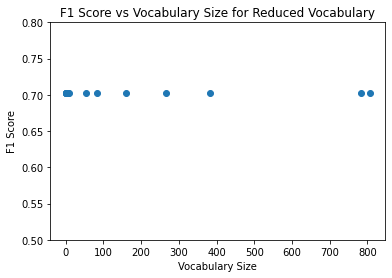

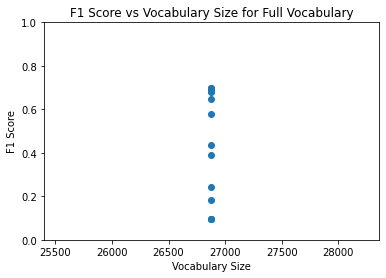

In [8]:
def Q6():
    # Keep this random seed here to make comparison easier.
    np.random.seed(0)

    ### STUDENT START ###
    vocab = []
    f1s = []
    vocab2 = []
    f1s2 = []
    #Run through different values of C.
    for c in [0.00001, 0.00005, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 2, 5]:
      print("C value = " + str(c))
      #Transform data
      cv = CountVectorizer()
      count_vector=cv.fit_transform(train_data)
      count_vector_dev=cv.transform(dev_data)
      vocabulary = np.asarray(cv.get_feature_names())
      #Run L1 regression.
      lr = LogisticRegression(penalty = 'l1', C = c, solver="liblinear", multi_class="auto", tol=0.015)
      lr.fit(count_vector, train_labels) 
      #Evaluate L1 regression
      dev_pred = lr.predict(count_vector_dev)
      lr_score = metrics.f1_score(dev_labels, dev_pred, average = "weighted")
      print("Vocabulary size is: " + str(count_vector.shape[1]))
      print("F1 value: " + str(lr_score))
      #Assign values for chart.
      vocab += [count_vector.shape[1]]
      f1s += [lr_score]

      #Get nonzero values and transform data.
      nonzero = np.nonzero(lr.coef_[1])
      cv.vocabulary = np.unique(vocabulary[nonzero[0]])
      new_train = cv.transform(train_data)
      new_dev = cv.transform(dev_data)
      #Run new regression.
      lr2 = LogisticRegression(penalty = 'l2', C = 0.5, solver="liblinear", multi_class="auto", tol=0.015)
      lr2.fit(new_train, train_labels) 
      #Evaluate L2 regression.
      dev_pred2 = lr2.predict(new_dev)
      lr_score2 = metrics.f1_score(dev_labels, dev_pred2, average = "weighted")
      print("New vocabulary size is: " + str(len(cv.vocabulary)))
      print("F1 value for L2: " + str(lr_score2))
      print("------------------------------------------------------------")
      #Assign values for chart
      vocab2 += [len(cv.vocabulary)]
      f1s2 += [lr_score2]
    
    plt.plot(vocab2, f1s2, 'o')
    plt.title('F1 Score vs Vocabulary Size for Reduced Vocabulary')
    plt.xlabel('Vocabulary Size')
    plt.ylabel('F1 Score')
    plt.ylim((0.5, 0.8))
    plt.show()

    plt.plot(vocab, f1s, 'o')
    plt.title('F1 Score vs Vocabulary Size for Full Vocabulary')
    plt.ylim((0.0, 1.0))
    plt.xlabel('Vocabulary Size')
    plt.ylabel('F1 Score')
    plt.show()

    ### STUDENT END ###

Q6()

ANSWER: For the same C values, the full size vocabulary does not perform better than the reduced vocabulary in terms of F1 scores. As vocabulary size increases in the first chart above, the F1 score stays relatively constant.

### Question 7: TfIdf
---
As you may recall [tf-idf](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) stands for *term frequency inverse document frequency* and is a way to assign a weight to each word or token signifying their importance for a document in a corpus (a collection of documents).

Produce a Logistic Regression model based on data represented in tf-idf form, with L2 regularization strength of 100.  Evaluate and show the f1 score.  How is `TfidfVectorizer` different than `CountVectorizer`?

1. How is `TfidfVectorizer` different than `CountVectorizer`?
1. Show the 3 documents with highest R ratio, where ...
  - $R\,ratio = maximum\,predicted\,probability \div predicted\,probability\,of\,correct\,label$
1. Explain what the R ratio describes.
1. What kinds of mistakes is the model making? Suggest a way to address one particular issue that you see.

Note:
* Train on the transformed training data.
* Evaluate on the transformed development data.
* You can use `TfidfVectorizer` and its `.fit_transform` method to transform data to tf-idf form.
* You can use `LogisticRegression(C=100, solver="liblinear", multi_class="auto")` to produce a logistic regression model.
* You can use `LogisticRegression`'s `.predict_proba` method to access predicted probabilities.

In [9]:
def Q7():
    ### STUDENT START ###
    #Transform data
    cv = TfidfVectorizer()
    count_vector = cv.fit_transform(train_data)
    count_vector_dev = cv.transform(dev_data)
    
    #Fit model
    lr = LogisticRegression(penalty='l2', C=100)
    lr.fit(count_vector, train_labels)
    dev_pred = lr.predict(count_vector_dev)
    pred_vals = lr.predict_proba(count_vector_dev)

    lr_score = metrics.f1_score(dev_labels, dev_pred, average = "weighted")
    print("F1 value for L2: " + str(lr_score))
        
    pred = []
    label = []
    txt = []
    R = []
    for i, j in enumerate(pred_vals):
        pred.append(newsgroups_train.target_names[np.argmax(j)])
        label.append(newsgroups_test.target_names[dev_labels[i]])
        txt.append(dev_data[i])
        R.append(np.max(j)/j[dev_labels[i]])
    
    for i in np.argpartition(R, -3)[-3:]: 
        print("------------------------------------------------")
        print("R: " + str(R[i]))
        print("Predicted: "+ str(pred[i]))
        print("Actual: " + str(label[i]))
        print("Text: \n" + str(txt[i]))
    ### STUDENT END ###

Q7()

F1 value for L2: 0.7557303806953157
------------------------------------------------
R: 232.30677650717345
Predicted: alt.atheism
Actual: talk.religion.misc
Text: 
Why is the NT tossed out as info on Jesus.  I realize it is normally tossed
out because it contains miracles, but what are the other reasons?

MAC
--
****************************************************************
                                                    Michael A. Cobb
 "...and I won't raise taxes on the middle     University of Illinois
    class to pay for my programs."                 Champaign-Urbana
          -Bill Clinton 3rd Debate             cobb@alexia.lis.uiuc.edu
------------------------------------------------
R: 470.96814861115604
Predicted: comp.graphics
Actual: talk.religion.misc
Text: 
I am pleased to announce that a *revised version* of _The Easy-to-Read Book
of Mormon_ (former title: _Mormon's Book_) by Lynn Matthews Anderson is now
available through anonymous ftp (see information below). In a

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


ANSWER: 
- While CountVectorizer uses word frequencies across documents, the TFIDF Vectorizer uses the frequency in each document as well. 
- Here, the R ratio describes by how many times the model predicts incorrect classifications, with a ratio of 1 being a correct classification. The larger the R value, the worse the mistake because the model was more confident about it despite it being wrong. 
- Here, the mistakes being made are all for texts that are actually part of the religion topic. This is not surprising because each of the posts also contain religion-related language such as "Jesus" and "Book of Mormon". It is even possible that some annotators might disagree with the current labels and agree with the classifier. Because of this, my suggestion to address this is to include more than one topic label for posts like these that are related to multiple topics.

### Question 8 EXTRA CREDIT:
---
Produce a Logistic Regression model to implement your suggestion from Part 7.